# Train Mask Detector

### importing  packages

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

### initializing the initial learning rate, number of epochs to train for, and batch size

In [9]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"C:\Users\SOLA\Downloads\Dejavu\New\Freelance Project\New folder\Face-Mask-Detection\dataset"
CATEGORIES = ["with_mask", "without_mask"]

### grabbing the list of images, initializing the list of data (i.e., images) and class images

In [10]:
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

[INFO] loading images...


C:\Users\SOLA\anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### performing one-hot encoding on the labels

In [11]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

### constructing the training image generator for data augmentation

In [12]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [13]:
# loading the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 15s 2us/step


### constructing the head of the model which will be placed on top of the base model

In [14]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [15]:
# placing the head FC model on top of the base model (this will become the actual model that is trained)
model = Model(inputs=baseModel.input, outputs=headModel)

In [16]:
# looping over all layers in the base model and then freezing them so they will *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [17]:
# compiling the model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


### training the head of the network

In [18]:
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 1165s 12s/step - loss: 0.3053 - accuracy: 0.8708 - val_loss: 0.0818 - val_accuracy: 0.9844
Epoch 2/20
95/95 [==============================] - 2219s 23s/step - loss: 0.1029 - accuracy: 0.9647 - val_loss: 0.0549 - val_accuracy: 0.9844
Epoch 3/20
95/95 [==============================] - 18115s 191s/step - loss: 0.0766 - accuracy: 0.9736 - val_loss: 0.0505 - val_accuracy: 0.9870
Epoch 4/20
95/95 [==============================] - 1184s 12s/step - loss: 0.0657 - accuracy: 0.9779 - val_loss: 0.0351 - val_accuracy: 0.9935
Epoch 5/20
95/95 [==============================] - 1143s 12s/step - loss: 0.0469 - accuracy: 0.9832 - val_loss: 0.0318 - val_accuracy: 0.9922
Epoch 6/20
95/95 [==============================] - 1128s 12s/step - loss: 0.0524 - accuracy: 0.9809 - val_loss: 0.0390 - val_accuracy: 0.9896
Epoch 7/20
95/95 [==============================] - 30316s 319s/step - loss: 0.0412 - accuracy: 0.9868 - val_loss: 0

In [19]:
# making predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [20]:
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [21]:
# showing a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [22]:
# serializing the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


### plotting the training loss and accuracy

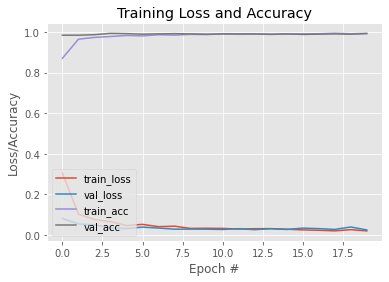

In [23]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")